In [105]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

### Data preparation/preprocessing

In [2]:
data = pd.read_csv('mhealth_full.csv')

In [20]:
# Below function resamples the same number of observations from each activity category
def resample_data(data, num_observations):
    resampled_data = pd.DataFrame()
    for i in range(0, 13):
        data_activity_i = data[data['activity'] == i]
        data_activity_i = data_activity_i.sample(n=num_observations, random_state=1)
        resampled_data = pd.concat([data_activity_i, resampled_data])
    return resampled_data

In [21]:
# Resample data for better computation time (3000 observations from each category per EDA)
data = resample_data(data, 3000)

In [22]:
# Split data between predictors and output variable
X = data.drop(['activity', 'subject'], axis=1)
y = data['activity']

In [23]:
# Create scaled version of full predictor set in case using cross validation techniques
X_scaled = StandardScaler().fit_transform(X)

In [24]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [25]:
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# Results summarizer function (scores, confusion matrix) for classification results
def results_summarizer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    activity_map = {
        0: 'Null',
        1: 'Standing still',  
        2: 'Sitting and relaxing', 
        3: 'Lying down',  
        4: 'Walking',  
        5: 'Climbing stairs',  
        6: 'Waist bends forward',
        7: 'Frontal elevation of arms', 
        8: 'Knees bending (crouching)', 
        9: 'Cycling', 
        10: 'Jogging', 
        11: 'Running', 
        12: 'Jump front & back' 
    }
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
                xticklabels=activity_map.values(),
                yticklabels=activity_map.values()
               ) 
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Activity')
    plt.ylabel('Actual Activity')
    plt.show()
    
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F_1 Score: ' + '{:.4%}'.format(f1))

### Models - Logistic Regression

In [125]:
# Logistic regression with newton-cg solver
log_reg = LogisticRegression(solver='newton-cg', max_iter=300)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=300, solver='newton-cg')

In [126]:
y_pred_log = log_reg.predict(X_test_scaled)

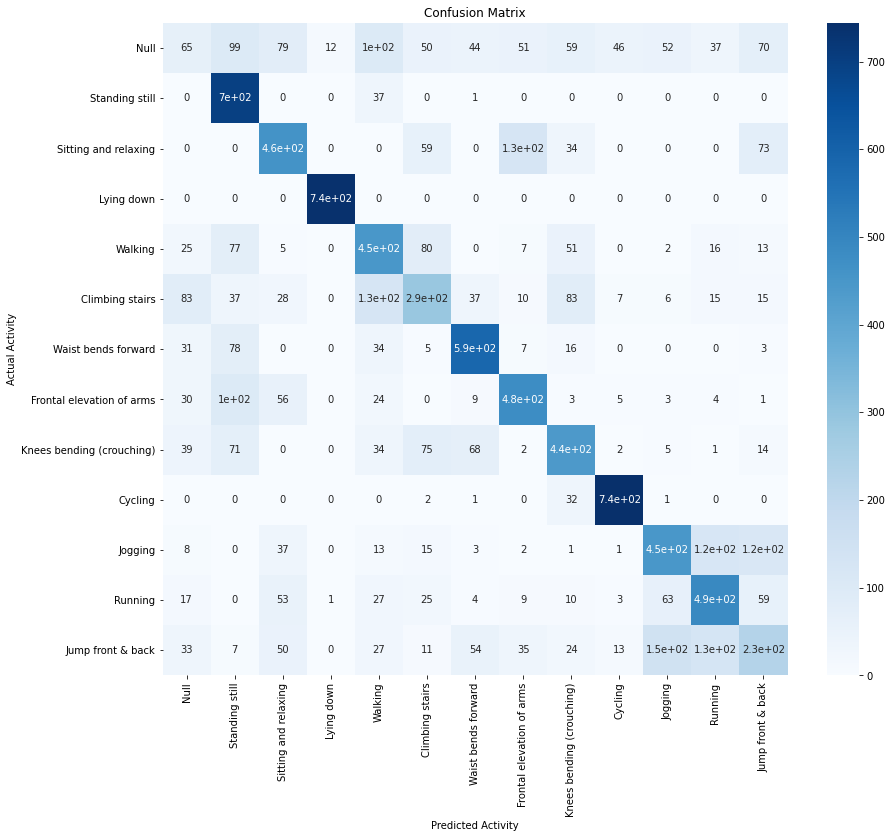

Accuracy Score: 62.7692%
Precision Score: 60.3380%
Recall Score: 62.8436%
F_1 Score: 60.9891%


In [127]:
results_summarizer(y_test, y_pred_log)

In [30]:
# Logistic regression with lbfgs solver
log_reg = LogisticRegression(solver='lbfgs', max_iter=400)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=400)

In [31]:
y_pred_log_2 = log_reg.predict(X_test_scaled)

In [ ]:
results_summarizer(y_test, y_pred_log_2)

In [86]:
# Cross validation on logistic regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=400)
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=5)
# Print cross val scores along with average
print(cv_scores)
print(f'cv_scores mean:{np.mean(cv_scores)}')

[0.62794872 0.6274359  0.62307692 0.62615385 0.64025641]
cv_scores mean:0.6289743589743589


Note: Baseline logistic regression classification accuracy scores are much lower than other types of models. Therefore, will proceed with other model types

### Models - KNN

In [33]:
# KNN with k=5
# Note: Achieved accuracy score of 96.55% with full dataset. Runtime was very long
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

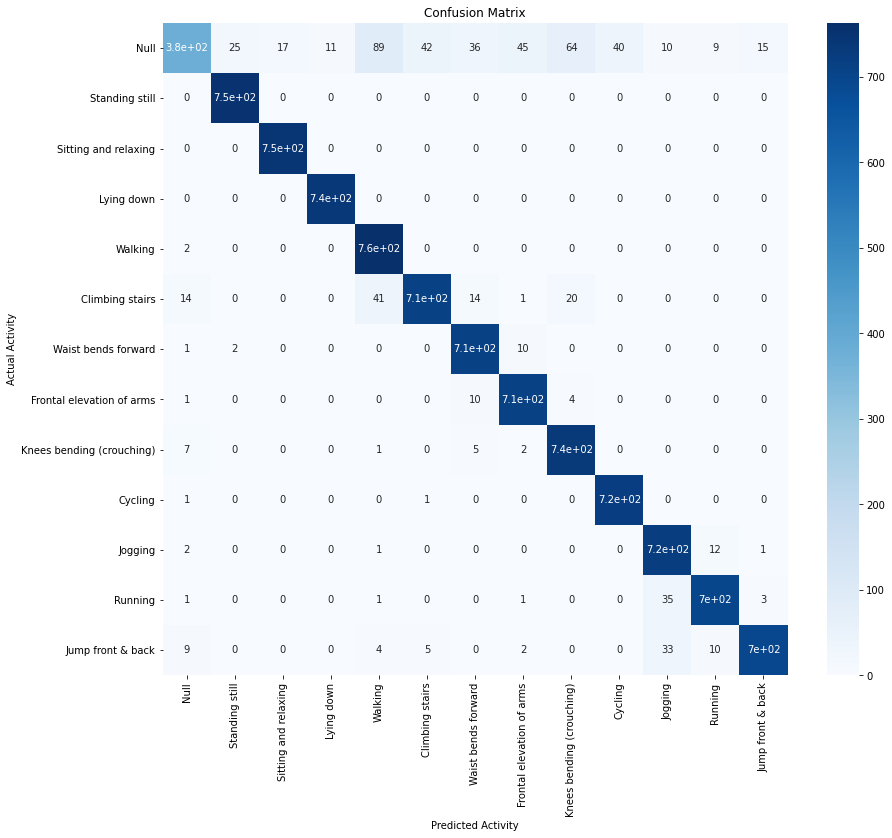

Accuracy Score: 93.2308%
Precision Score: 93.3327%
Recall Score: 93.4497%
F_1 Score: 92.7844%


In [50]:
results_summarizer(y_test, y_pred_knn)

In [17]:
# Get cross val score for knn with k = 5
knn = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn, X_scaled, y, cv=5)
# Print cross val scores along with average
print(cv_scores)
print(f'cv_scores mean:{np.mean(cv_scores)}')

[0.42510998 0.58403648 0.38510089 0.39254911 0.45573192]
cv_scores mean:0.44850567642378614


In [36]:
# Large discrepancy between single model and CV. Possible overfitting? Shuffle data for CV per source:
# https://datascience.stackexchange.com/questions/30702/why-is-cross-validation-score-so-low
X_scaled_shuffled, y_shuffled = shuffle(X_scaled, y)

knn = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn, X_scaled_shuffled, y_shuffled, cv=5)
# Print cross val scores along with average
print(cv_scores)
print(f'cv_scores mean:{np.mean(cv_scores)}')

[0.93448718 0.93397436 0.93371795 0.93269231 0.93410256]
cv_scores mean:0.9337948717948719


In [66]:
# KNN with k=3 (and shuffled data sets)
knn = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(knn, X_scaled_shuffled, y_shuffled, cv=5)
# Print cross val scores along with average
print(cv_scores)
print(f'cv_scores mean:{np.mean(cv_scores)}')

[0.94025641 0.94269231 0.94128205 0.93987179 0.93910256]
cv_scores mean:0.9406410256410256


Note: Much better cross-validated performance using KNNs

### Models - Support Vector Machine Classification

In [43]:
# Per Anguita et. al., Attempting SVM classifier to obtain better results than KNN
# Support Vector Classifier - linear kernal - tuning C parameter with CV
cost_choices = [0.025, 0.05, 0.1, 1, 5, 10]
for c in cost_choices:
    svc = SVC(kernel='linear', random_state=1, C=c)
    score = cross_val_score(svc, X_scaled, y, cv=5).mean()
    print(f'Cost value: {c}', f'Cross-validation score: {score}')

Cost value: 0.025 Cross-validation score: 0.7059487179487179
Cost value: 0.05 Cross-validation score: 0.7126410256410257
Cost value: 0.1 Cross-validation score: 0.7174358974358974
Cost value: 1 Cross-validation score: 0.7254871794871793
Cost value: 5 Cross-validation score: 0.727948717948718
Cost value: 10 Cross-validation score: 0.7283846153846154


In [52]:
# Support Vector Classifier - polynomial
svc = SVC(kernel='poly', random_state=1)
score = cross_val_score(svc, X_scaled, y, cv=5).mean()
print(f'Cross-validation score: {score}')

Cross-validation score: 0.8750769230769231


In [53]:
# Support Vector Classifier - radial
svc = SVC(kernel='rbf', random_state=1)
score = cross_val_score(svc, X_scaled, y, cv=5).mean()
print(f'Cross-validation score: {score}')

Cross-validation score: 0.9228205128205127


Radial SVC appears to give the best accuracy. Hypertuning:

In [55]:
# Radial with different regularization params
cost_choices = [0.025, 0.05, 0.1, 1, 5, 10]
for c in cost_choices:
    svc = SVC(kernel='rbf', random_state=1, C=c)
    score = cross_val_score(svc, X_scaled, y, cv=5).mean()
    print(f'Cost value: {c}', f'Cross-validation score: {score}')

Cost value: 0.025 Cross-validation score: 0.764025641025641
Cost value: 0.05 Cross-validation score: 0.8137179487179488
Cost value: 0.1 Cross-validation score: 0.8509743589743589
Cost value: 1 Cross-validation score: 0.9228205128205127
Cost value: 5 Cross-validation score: 0.9480000000000001
Cost value: 10 Cross-validation score: 0.9524358974358973


In [58]:
# Radial with different gamma choices
gamma_choices = [0.0005, 0.001, 0.01, 0.1, 1, 5]
for g in gamma_choices:
    svc = SVC(kernel='rbf', random_state=1, gamma=g, C=10)
    score = cross_val_score(svc, X_scaled, y, cv=5).mean()
    print(f'Gamma value: {g}', f'Cross-validation score: {score}')

Gamma value: 0.0005 Cross-validation score: 0.7362051282051283
Gamma value: 0.001 Cross-validation score: 0.7817435897435897
Gamma value: 0.01 Cross-validation score: 0.9072820512820513
Gamma value: 0.1 Cross-validation score: 0.9564102564102563
Gamma value: 1 Cross-validation score: 0.825205128205128
Gamma value: 5 Cross-validation score: 0.6094871794871796


In [128]:
# Produce confusion matrix for hypertuned SVC
svc = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)

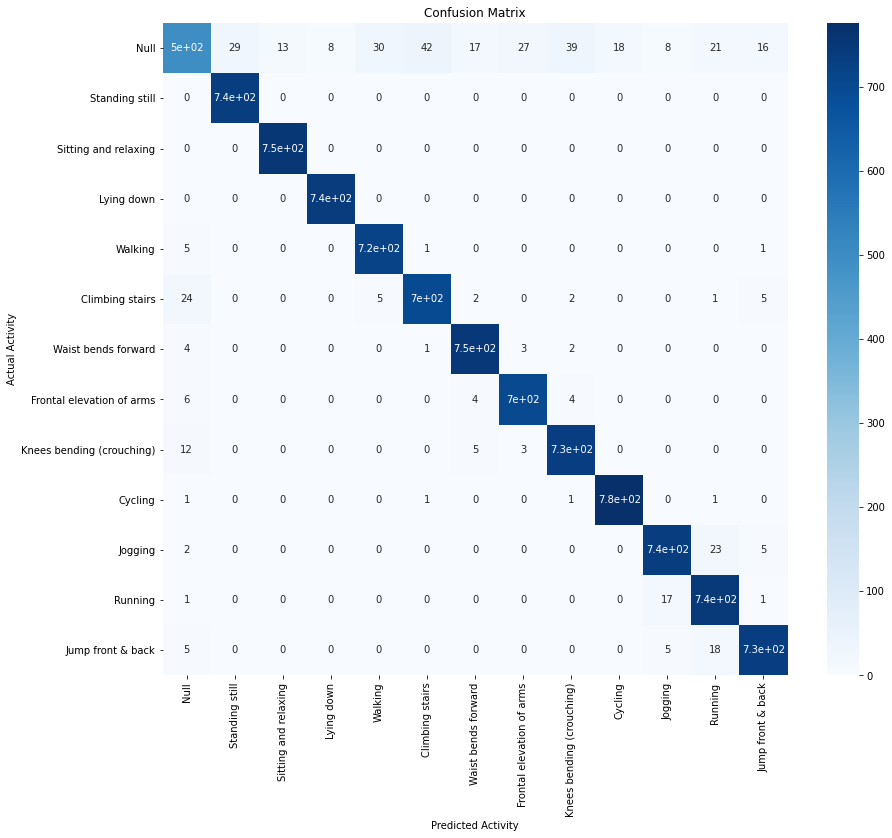

Accuracy Score: 95.4974%
Precision Score: 95.3781%
Recall Score: 95.5509%
F_1 Score: 95.2999%


In [129]:
results_summarizer(y_test, y_pred_svc)

### Models - Random Forest Classifier (Ensemble)

In [85]:
# Per Casale et. al., trying Random Forest Classifier
# Try default params Random Forest Classifier
rfst = RandomForestClassifier(random_state=1)
score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
print(f'Cross-validation score: {score}')

Cross-validation score: 0.9577692307692308


Off the bat, default Random Forest Classifier is resulting in a very good cross-validated accuracy score.

In [92]:
# Hypertuning Random Forest using GridSearchCV takes too long. Looping over params:
# number of estimators
n_estimator_choices = [100, 200, 300]
for n in n_estimator_choices:
    rfst = RandomForestClassifier(random_state=1, n_estimators=n)
    score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
    print(f'Number of estimators: {n}', f'Cross-validation score: {score}')

Number of estimators: 100 Cross-validation score: 0.9577692307692308
Number of estimators: 200 Cross-validation score: 0.9594102564102565
Number of estimators: 300 Cross-validation score: 0.9594102564102563


In [110]:
# Tune max depth
max_depth_choices = [10, 20, 30, 40]
for d in max_depth_choices:
    rfst = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=d)
    score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
    print(f'Max depth: {d}', f'Cross-validation score: {score}')

Max depth: 10 Cross-validation score: 0.8976666666666666
Max depth: 20 Cross-validation score: 0.9565897435897437
Max depth: 30 Cross-validation score: 0.9586410256410256
Max depth: 40 Cross-validation score: 0.9590769230769232


In [112]:
# Try with entropy criterion
rfst = RandomForestClassifier(random_state=1, n_estimators=200, criterion='entropy')
score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
print(f'Cross-validation score: {score}')

Cross-validation score: 0.9573333333333334


In [115]:
# Tune minimum samples required to be at leaf node
min_samples_leaf_choices = [1, 2, 4]
for m in min_samples_leaf_choices:
    rfst = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=None, min_samples_leaf=m)
    score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
    print(f'Minimum samples required at leaf node: {m}', f'Cross-validation score: {score}')

Minimum samples required at leaf node: 1 Cross-validation score: 0.9594102564102565
Minimum samples required at leaf node: 2 Cross-validation score: 0.9558461538461538
Minimum samples required at leaf node: 4 Cross-validation score: 0.9507692307692308


In [117]:
# Tune minimum samples required to split internal node
min_samples_split_choices = [2, 5, 10]
for m in min_samples_split_choices:
    rfst = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=None, min_samples_leaf=1, 
                                  min_samples_split=m)
    score = cross_val_score(rfst, X_scaled, y, cv=5).mean()
    print(f'Minimum samples required at leaf node: {m}', f'Cross-validation score: {score}')

Minimum samples required at leaf node: 2 Cross-validation score: 0.9594102564102565
Minimum samples required at leaf node: 5 Cross-validation score: 0.9579487179487179
Minimum samples required at leaf node: 10 Cross-validation score: 0.9553846153846154


In [118]:
# Produce confusion matrix for hyptertuned Random Forest Classifier
rfst = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=None, min_samples_leaf=1, min_samples_split=2)
rfst.fit(X_train_scaled, y_train)
y_pred_rfst = rfst.predict(X_test_scaled)

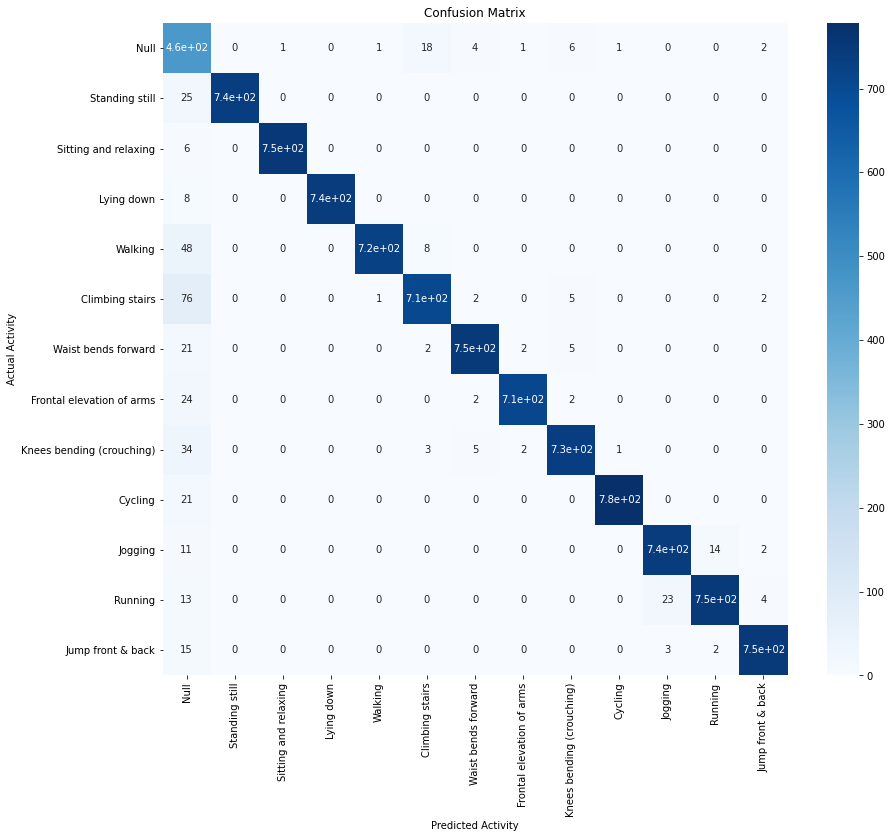

Accuracy Score: 95.6308%
Precision Score: 95.6948%
Recall Score: 95.5923%
F_1 Score: 95.3475%


In [119]:
results_summarizer(y_pred_rfst, y_test)